In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import f,t
import itertools

/kaggle/input/gym-members-exercise-dataset/gym_members_exercise_tracking.csv


1. Préparation et filtrage des données (brièvement mentionné à l'oral)
Chargement du dataset et exclusion des variables non pertinentes

Suppression des valeurs manquantes / outliers (Z-score ou IQR)

Standardisation uniquement des variables explicatives


In [ ]:
df = pd.read_csv("gym_members_exercise_tracking.csv")

# On garde uniquement les variables continues pour l'analyse (Calories_Burned incluse)
continuous_vars = [
    "Age", "Weight (kg)", "Height (m)", "Max_BPM", "Avg_BPM", "Resting_BPM",
    "Calories_Burned", "Fat_Percentage", "Water_Intake (liters)", "BMI"
]
df = df[continuous_vars]

df

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Calories_Burned,Fat_Percentage,Water_Intake (liters),BMI
0,56,88.3,1.71,180,157,60,1313.0,12.6,3.5,30.20
1,46,74.9,1.53,179,151,66,883.0,33.9,2.1,32.00
2,32,68.1,1.66,167,122,54,677.0,33.4,2.3,24.71
3,25,53.2,1.70,190,164,56,532.0,28.8,2.1,18.41
4,38,46.1,1.79,188,158,68,556.0,29.2,2.8,14.39
...,...,...,...,...,...,...,...,...,...,...
968,24,87.1,1.74,187,158,67,1364.0,10.0,3.5,28.77
969,25,66.6,1.61,184,166,56,1260.0,25.0,3.0,25.69
970,59,60.4,1.76,194,120,53,929.0,18.8,2.7,19.50
971,32,126.4,1.83,198,146,62,883.0,28.2,2.1,37.74


---------------------------------------------------------------------------------------------
2. Exploration rapide et visualisation (facultatif à l’oral, mais bon à avoir en back-up)
Histogrammes / boxplots des variables continues

Matrice de corrélation (heatmap)

Scatterplots Calories_Burned vs chaque variable continue


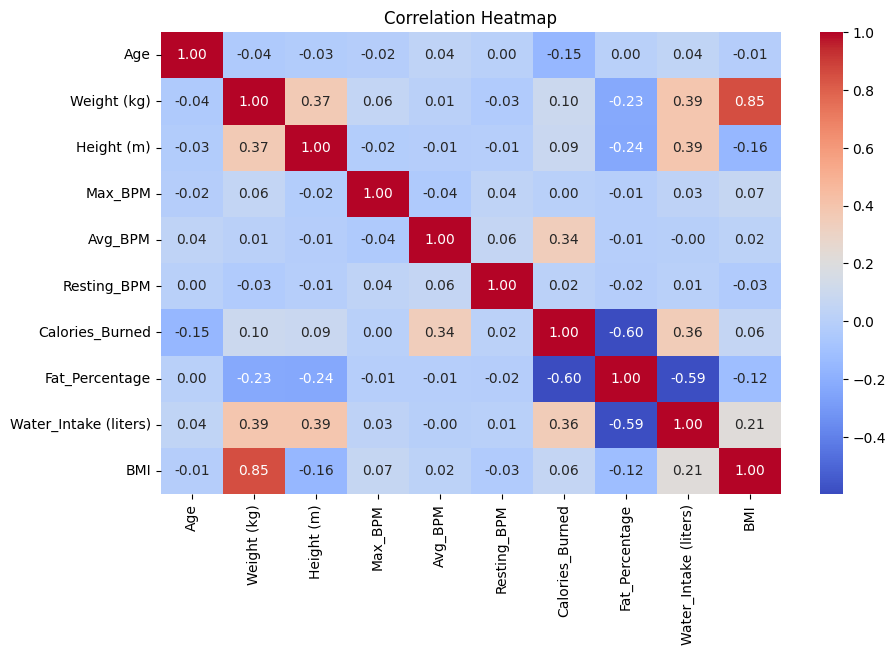

In [64]:
# Compute the correlation matrix
corr = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

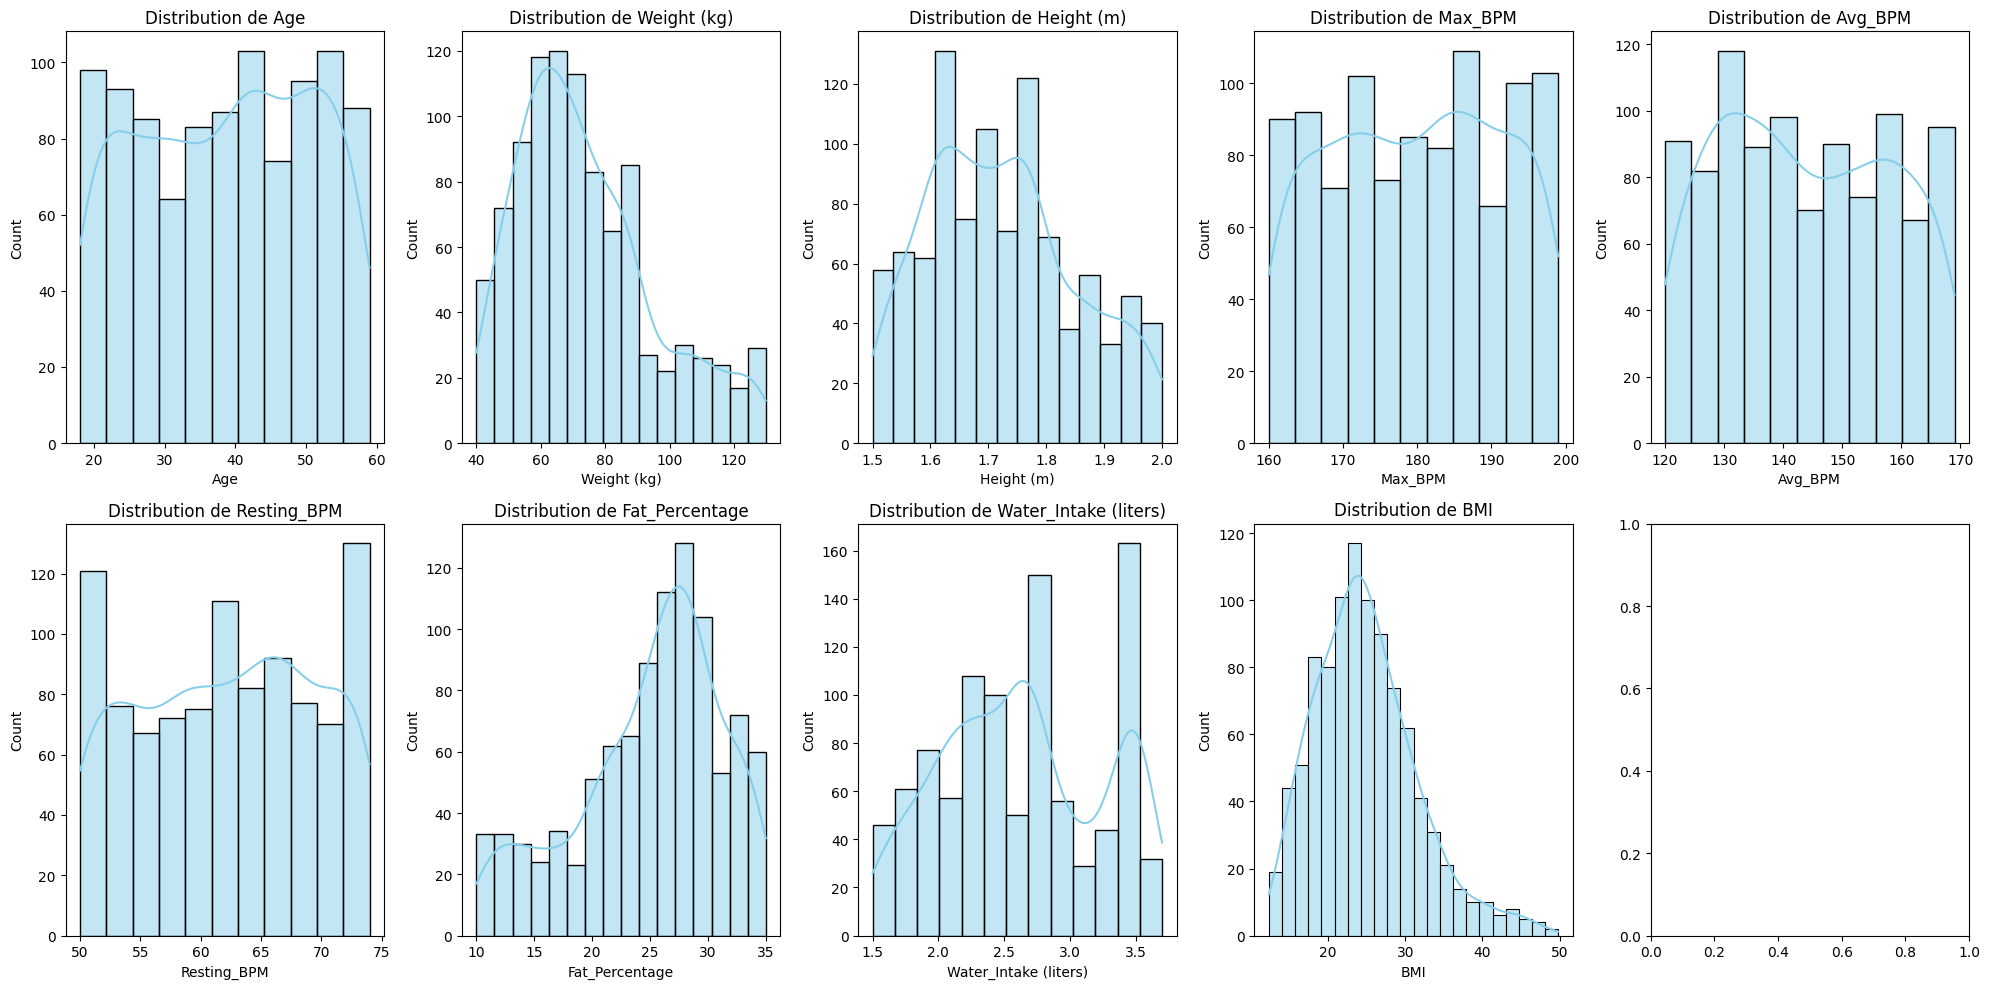

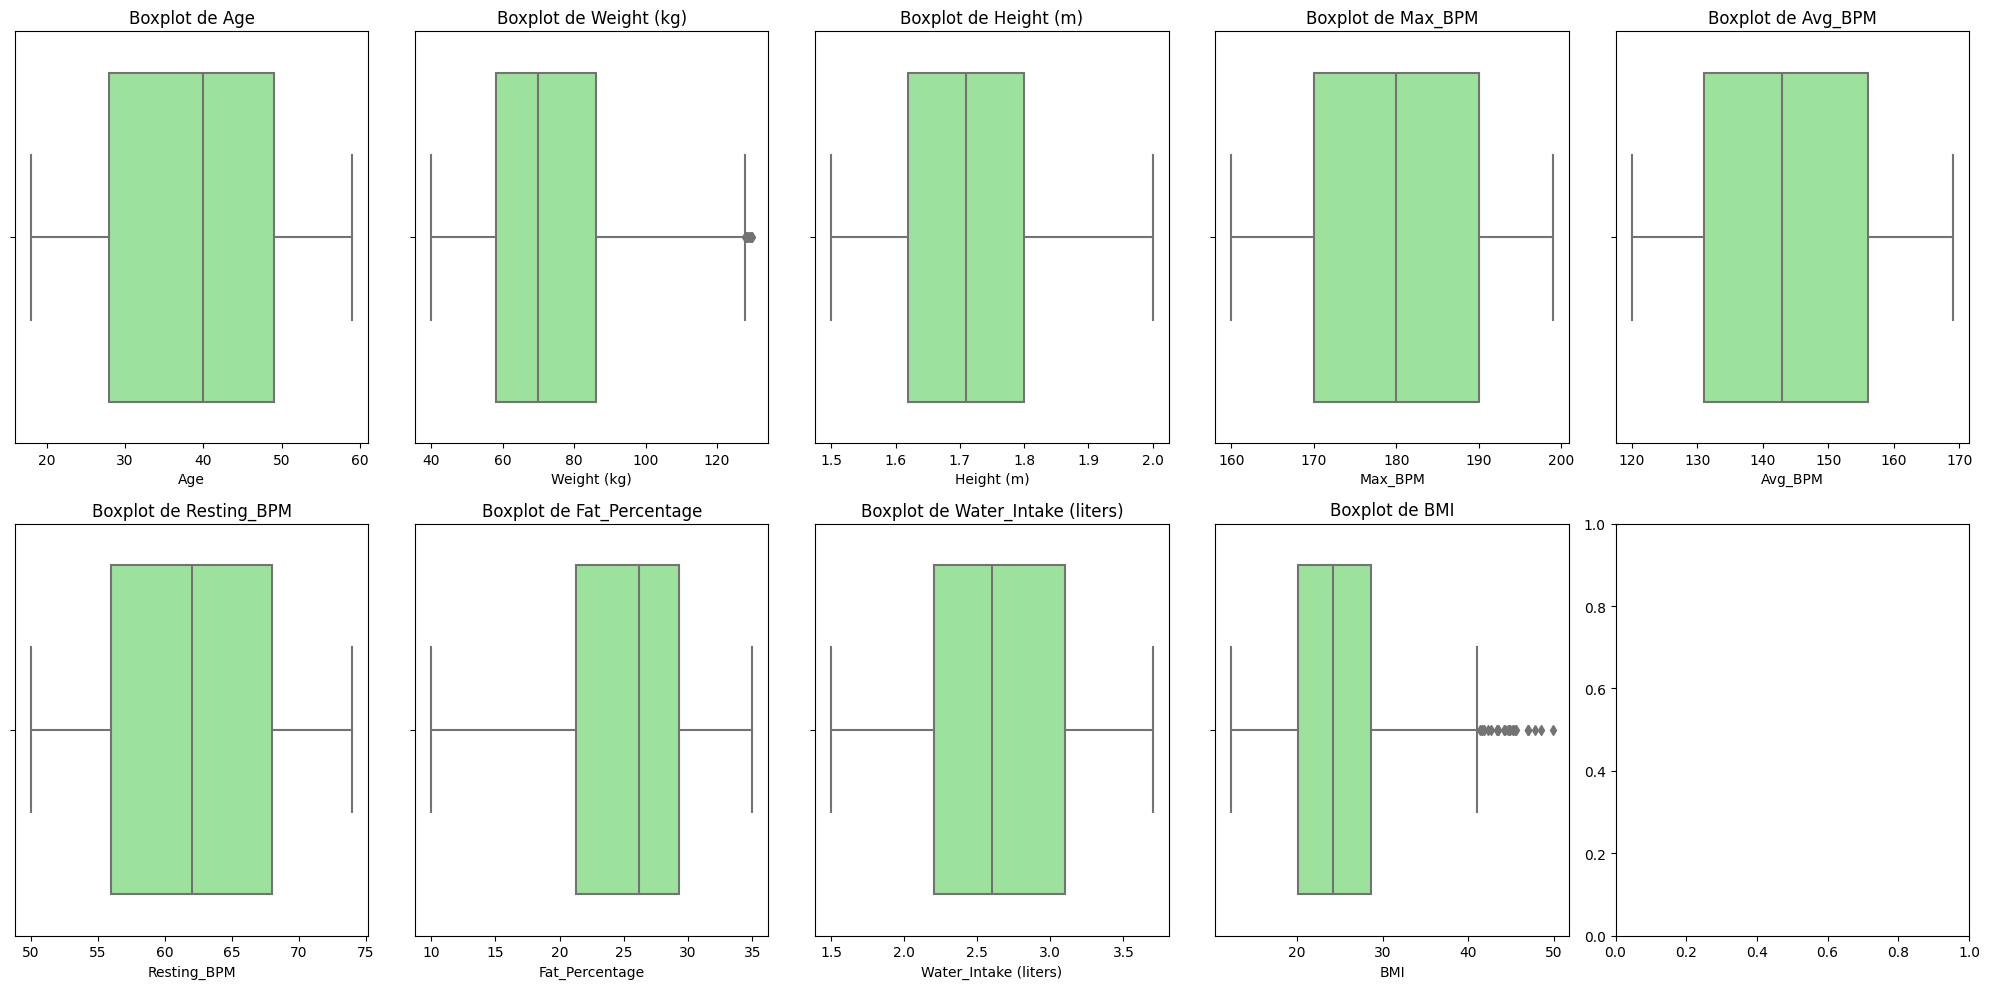

In [65]:
# Étape 1 : Préparation et filtrage des données

# Séparation des variables explicatives et de la cible
X = df.drop(columns=['Calories_Burned'])
y = df['Calories_Burned']

# Standardisation des variables explicatives
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 1. Histogrammes et boxplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
axes = axes.flatten()
for i, col in enumerate(X.columns):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution de {col}')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
axes = axes.flatten()
for i, col in enumerate(X.columns):
    sns.boxplot(x=df[col], ax=axes[i], color='lightgreen')
    axes[i].set_title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

3. Modélisation principale
Régression multiple initiale : toutes les variables numériques explicatives

Affichage de :

Coefficients + p-values

R², R² ajusté

AIC / BIC

F-statistique

Résidus : QQ-plot + résidus vs prédictions

Distance de Cook + leverage plots



In [66]:
### modele FULL
# 3. Standardize the continuous data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=continuous_vars)

# 4. Define features and target
X = df_scaled.drop(columns=["Calories_Burned"])  # Features
y = df_scaled["Calories_Burned"]                 # Target

# 5. Add constant and fit the model
X = sm.add_constant(X)
modele_full = sm.OLS(y, X).fit()

# 6. Display the model summary
print(modele_full.summary())



                            OLS Regression Results                            
Dep. Variable:        Calories_Burned   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     108.6
Date:                Tue, 20 May 2025   Prob (F-statistic):          6.38e-140
Time:                        12:44:13   Log-Likelihood:                -1039.8
No. Observations:                 973   AIC:                             2100.
Df Residuals:                     963   BIC:                             2148.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  9.888e-

F-statistic: 108.6
Prob (F-statistic): 6.38e-140 <<<0.05
On rejette l'hypothèse nulle → au moins une variable a un effet significatif sur le nombre de calories brûlées.

D’après les p-values individuelles :

variables non-significatives
- Weight (kg) 0.777
- Height (m) 0.589   
- Max_BPM 0.728  
- Avg_BPM 0.3427  
- Resting_BPM 0.492   
- BMI 0.986                     

Cela signifie que en présence des autres variables (Age, Avg_BPM, Fat_Percentage, BMI), ces variables n’ont pas d'effet significatif sur Calories_Burned.

Le fait qu'une variable ait une p-value élevée dans un modèle multivarié ne signifie pas nécessairement qu'elle est inutile. Elle peut :
- être utile en interaction avec une autre,
- devenir significative si certaines variables sont retirées (problèmes de colinéarité),
- contribuer à améliorer la prédiction globale même si elle n'est pas significative seule.

La bonne pratique serait :

Faire un test de Fisher partiel, pour tester simultanément la nullité des coefficients des variables non significatives (par exemple : tester que β_AGE = 0 dans le modèle avec LWT et SMOKE).

Ensuite, seulement si ce test global pour ces variables est non significatif, on pourrait considérer les retirer du modèle.

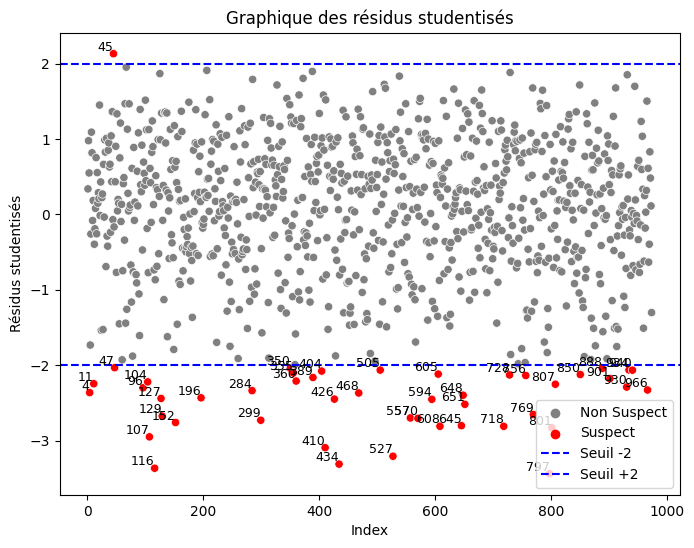

In [67]:
modele1 = modele_reduit_BE

# 1. Compute Studentized Residuals
residu_student = modele1.get_influence().resid_studentized_internal

# 2. Create DataFrame
df_residus = pd.DataFrame({"residu": residu_student})

# Number of observations
n = len(df["Calories_Burned"])

# 3. Identify Observations with |Residual| > 2 (Potential Outliers)
IDval_ab = np.where(np.abs(df_residus["residu"]) > 2)[0] + 1  # Convert to 1-based index

# 4. Add Identifier Column for Outliers
df_residus["ID"] = ""
df_residus.loc[IDval_ab - 1, "ID"] = IDval_ab  # Adjust back to 0-based index

# 5. Assign Groups Based on Residuals
df_residus["group"] = "Non Suspect"
df_residus.loc[IDval_ab - 1, "group"] = "Suspect"

# 6. Plot Studentized Residuals
plt.figure(figsize=(8, 6))

# Scatter plot with color for groups
sns.scatterplot(x=np.arange(1, n + 1), y=df_residus["residu"], hue=df_residus["group"], palette={"Non Suspect": "gray", "Suspect": "red"})

# Add threshold lines at ±2
plt.axhline(y=-2, color="blue", linestyle="dashed", label="Seuil -2")
plt.axhline(y=2, color="blue", linestyle="dashed", label="Seuil +2")

# 7. Add Labels for Outliers
for i, txt in enumerate(df_residus["ID"]):
    if txt:  # Only label outliers
        plt.text(i + 1, df_residus["residu"].iloc[i], s=txt, fontsize=9, verticalalignment='bottom', horizontalalignment='right')

# Labels and title
plt.xlabel("Index")
plt.ylabel("Résidus studentisés")
plt.title("Graphique des résidus studentisés")

# Add legend
plt.legend()

# Show plot
plt.show()

valeurs aberrantes

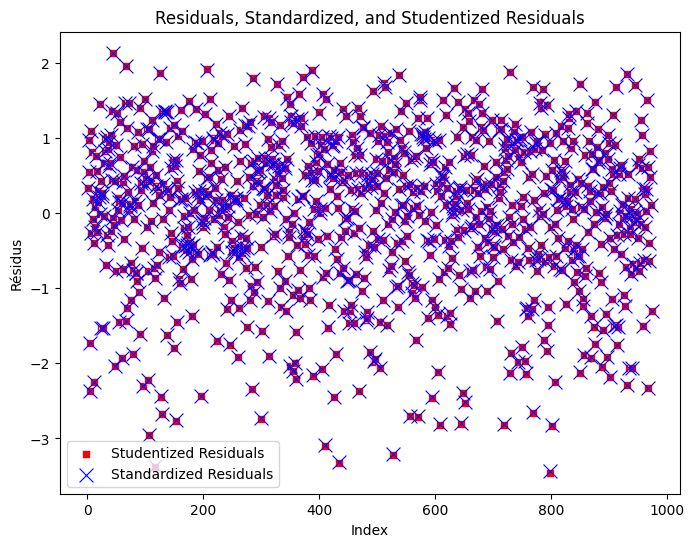

In [68]:
# Step 1: Get residuals (raw residuals e_i)
residuals = modele1.resid

# Step 2: Calculate sigma_hat (standard error of regression)
sigma_hat = np.sqrt(np.sum(residuals**2) / (len(residuals) - modele1.df_model - 1))

# Step 3: Get leverage (h_i)
influence = modele1.get_influence()
hii = influence.hat_matrix_diag  # Leverage values

# Step 4: Compute standardized residuals
standardized_residuals1 = residuals / (sigma_hat * np.sqrt(1 - hii))


# 1. Add the standardized residuals to the DataFrame
df_residus["residus_std"] = standardized_residuals1.values  # Standardized residuals
df_residus["residu"] = modele1.get_influence().resid_studentized_external  # Studentized residuals

# 2. Create the Plot
plt.figure(figsize=(8, 6))

# Plot raw residuals
# sns.scatterplot(x=np.arange(1, n+1), y=df_residus["residuals"], label="Residuals", color="black", marker="o")

# Plot studentized residuals
sns.scatterplot(x=np.arange(1, n+1), y=df_residus["residu"], label="Studentized Residuals", color="red", marker="s")
# Plot standardized residuals
sns.scatterplot(x=np.arange(1, n+1), y=df_residus["residus_std"], label="Standardized Residuals", color="blue", marker="x", s=100)

# 3. Add Labels and Title
plt.xlabel("Index")
plt.ylabel("Résidus")
plt.title("Residuals, Standardized, and Studentized Residuals")

# Add legend
plt.legend()

# Show plot
plt.show()

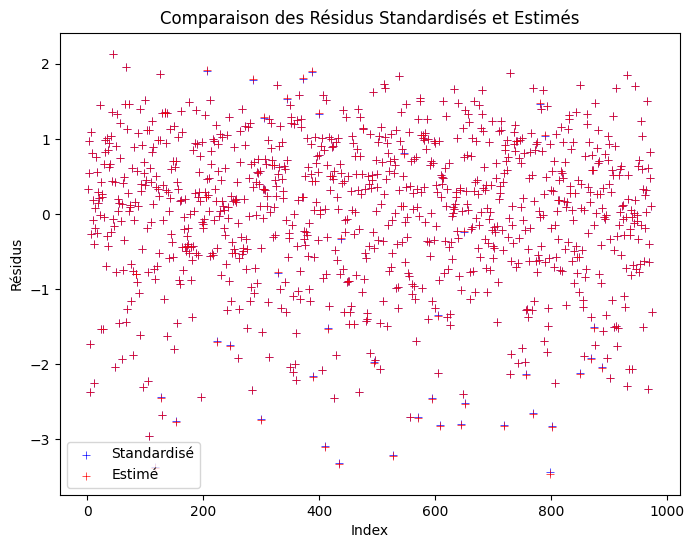

In [69]:
# 1. Create the Plot
plt.figure(figsize=(8, 6))

# Plot standardized residuals (blue)
sns.scatterplot(x=np.arange(1, n+1), y=df_residus["residus_std"], color="blue", label="Standardisé", marker="+")

# Plot studentized residuals (red)
sns.scatterplot(x=np.arange(1, n+1), y=df_residus["residu"], color="red", label="Estimé", marker="+")

# 2. Add Labels and Title
plt.xlabel("Index")
plt.ylabel("Résidus")
plt.title("Comparaison des Résidus Standardisés et Estimés")

# Add legend
plt.legend()

# Show plot
plt.show()

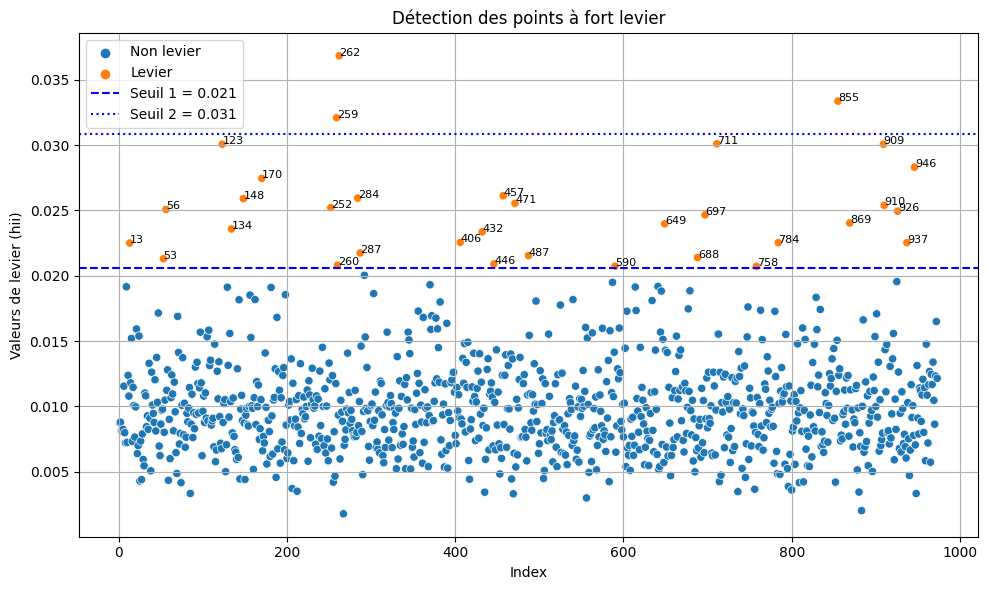

In [70]:
modele1 = modele_full
# 6. Valeurs de levier (hii)
influence = modele1.get_influence()
hat_values = influence.hat_matrix_diag
n = len(hat_values)
p = modele1.df_model + 1  # +1 pour l'intercept

# 7. Seuils
seuil1 = 2 * p / n
seuil2 = 3 * p / n

# 8. Préparer DataFrame
df_H = pd.DataFrame({
    'Index': range(1, n + 1),
    'hii': hat_values,
    'ID': '',
    'group': 'Non levier'
})

# 9. Marquer les points au-delà du seuil
df_H.loc[df_H['hii'] > seuil1, 'ID'] = df_H['Index']
df_H.loc[df_H['hii'] > seuil1, 'group'] = 'Levier'

# 10. Tracer
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_H, x='Index', y='hii', hue='group')
plt.axhline(y=seuil1, color='blue', linestyle='--', label=f'Seuil 1 = {seuil1:.3f}')
plt.axhline(y=seuil2, color='blue', linestyle=':', label=f'Seuil 2 = {seuil2:.3f}')

# Affichage des étiquettes
for _, row in df_H[df_H['group'] == 'Levier'].iterrows():
    plt.text(row['Index'] + 0.3, row['hii'], str(int(row['ID'])), fontsize=8)

plt.xlabel('Index')
plt.ylabel('Valeurs de levier (hii)')
plt.title('Détection des points à fort levier')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


2 seuils: 

/2n et /3n

--> Points leviers puissnats et super puissants

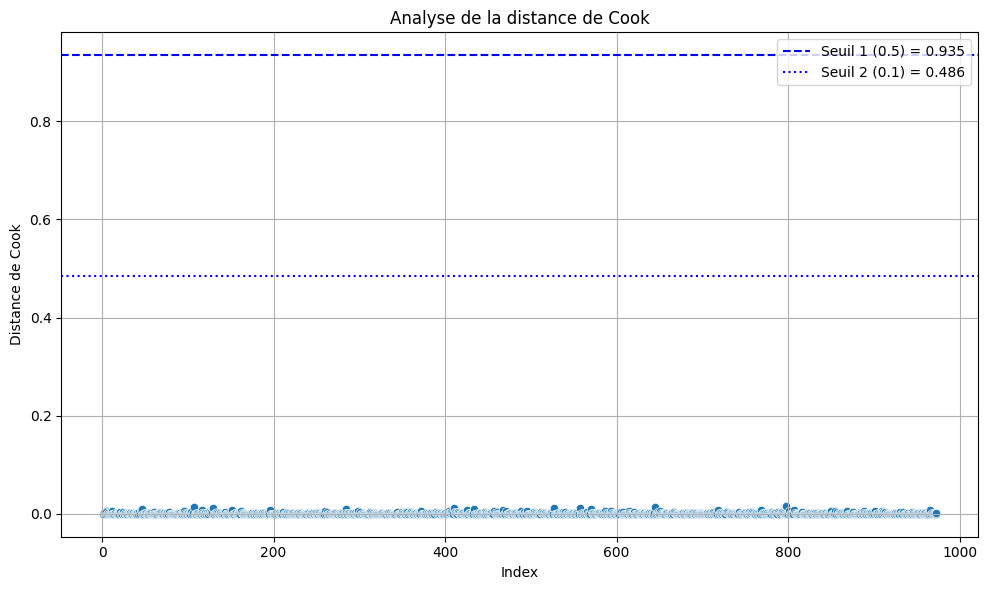

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


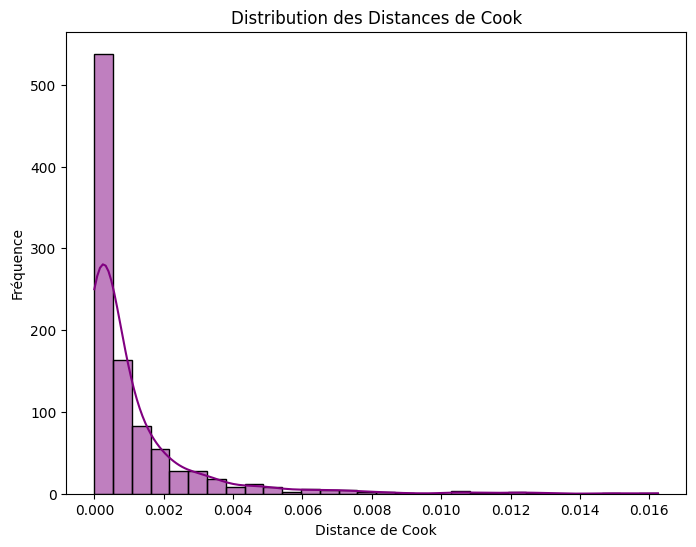

In [71]:

# 1. Distance de Cook
influence = modele1.get_influence()
cooks_d = influence.cooks_distance[0]


# 2. Taille de l’échantillon et degrés de liberté
n = len(cooks_d)
p = int(modele1.df_model + 1)  # +1 pour inclure l'intercept

# 3. Seuils à partir de la loi F
s1 = f.ppf(0.5, p, n - p)
s2 = f.ppf(0.1, p, n - p)

# 4. Création du DataFrame
df_cook = pd.DataFrame({
    'Index': range(1, n + 1),
    'Cook': cooks_d
})

# 5. Tracé avec seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cook, x='Index', y='Cook')
plt.axhline(y=s1, color='blue', linestyle='--', label=f'Seuil 1 (0.5) = {s1:.3f}')
plt.axhline(y=s2, color='blue', linestyle=':', label=f'Seuil 2 (0.1) = {s2:.3f}')
plt.xlabel('Index')
plt.ylabel('Distance de Cook')
plt.title('Analyse de la distance de Cook')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Distribution des distances de Cook
plt.figure(figsize=(8, 6))
sns.histplot(cooks_d, bins=30, kde=True, color='purple')
plt.title("Distribution des Distances de Cook")
plt.xlabel("Distance de Cook")
plt.ylabel("Fréquence")
plt.show()

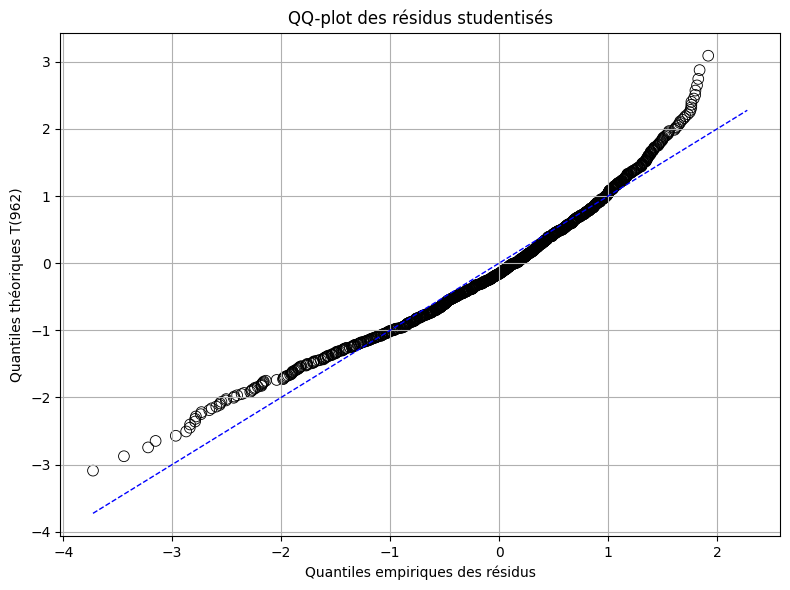

In [72]:
resid_student = modele1.get_influence().resid_studentized_internal
n = len(resid_student)
p = int(modele1.df_model + 1)

# 2. Calcul des quantiles théoriques de Student T(n - p - 1)
quant_t = t.ppf((np.arange(1, n + 1)) / n, df=n - p - 1)

# 3. DataFrame pour le QQ-plot
df_qq = pd.DataFrame({
    'Empirical': np.sort(resid_student),
    'Theoretical': np.sort(quant_t)
})

# 4. QQ-plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_qq, x='Empirical', y='Theoretical', s=60, edgecolor='black', facecolor='none')
plt.plot([df_qq['Empirical'].min(), df_qq['Empirical'].max()],
         [df_qq['Empirical'].min(), df_qq['Empirical'].max()],
         linestyle='--', color='blue', linewidth=1)

plt.xlabel("Quantiles empiriques des résidus")
plt.ylabel(f"Quantiles théoriques T({n - p - 1})")
plt.title("QQ-plot des résidus studentisés")
plt.grid(True)
plt.tight_layout()
plt.show()

ajustement du modèle est correct, mais on pourrait encore l'améliorer

In [73]:
X

,const,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Fat_Percentage,Water_Intake (liters),BMI
0,1.0,1.422343,0.681493,-0.098545,0.010081,0.922970,-0.303555,-1.978321,1.455967,0.794278
1,1.0,0.600965,0.049316,-1.508604,-0.076726,0.504494,0.515749,1.426301,-0.877898,1.064652
2,1.0,-0.548964,-0.271491,-0.490228,-1.118414,-1.518142,-1.122858,1.346380,-0.544488,-0.030361
3,1.0,-1.123928,-0.974433,-0.176881,0.878155,1.411193,-0.849757,0.611110,-0.877898,-0.976669
4,1.0,-0.056137,-1.309393,0.528148,0.704540,0.992716,0.788850,0.675047,0.289035,-1.580503
...,...,...,...,...,...,...,...,...,...,...
968,1.0,-1.206066,0.624880,0.136465,0.617733,0.992716,0.652299,-2.393908,1.455967,0.579482
969,1.0,-1.123928,-0.342257,-0.881911,0.357311,1.550685,-0.849757,0.003713,0.622444,0.116842
970,1.0,1.668756,-0.634756,0.293138,1.225384,-1.657634,-1.259409,-0.987304,0.122330,-0.812942
971,1.0,-0.548964,2.478951,0.841495,1.572614,0.155764,-0.030454,0.515205,-0.877898,1.926843


In [74]:
### VIF

# 2. Ajouter une constante (intercept)
X_const = sm.add_constant(X)

# 4. Calculer les VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# 5. Afficher les VIF
print(vif_data)

                Variable        VIF
0                  const   1.000000
1                    Age   1.013537
2            Weight (kg)  71.434503
3             Height (m)  20.492250
4                Max_BPM   1.009721
5                Avg_BPM   1.008028
6            Resting_BPM   1.007329
7         Fat_Percentage   1.534102
8  Water_Intake (liters)   1.850763
9                    BMI  63.950890


In [75]:
### modele_moins_VIF

# Standardize the continuous data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=continuous_vars)

# 1. Exclure deux colonnes (par exemple, colonnes 3 et 4 dans l'esprit de oz[, -c(3,4)])
cols_to_exclude = ["Height (m)", "Weight (kg)"] 
df_scaled = df_scaled.drop(columns=cols_to_exclude)
X = df_scaled.drop(columns = ["Calories_Burned"])  # tout sauf cible + exclues
y = df_scaled["Calories_Burned"]  # cible

# 2. Ajouter constante (intercept)
X_const = sm.add_constant(X)

# 3. Ajuster le modèle linéaire
modele_moins_VIF = sm.OLS(y, X_const).fit()

# 4. Résumé du modèle
print(modele_moins_VIF.summary())

### VIF

# 2. Ajouter une constante (intercept)
X_const = sm.add_constant(X)

# 4. Calculer les VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# 5. Afficher les VIF
print(vif_data)

                            OLS Regression Results                            
Dep. Variable:        Calories_Burned   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     136.8
Date:                Tue, 20 May 2025   Prob (F-statistic):          9.13e-140
Time:                        12:44:16   Log-Likelihood:                -1045.2
No. Observations:                 973   AIC:                             2106.
Df Residuals:                     965   BIC:                             2145.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  9.888e-

✅ Résumé du nouveau modèle (mod1)
🔍 Résultats principaux :
R² = 0.498, adj R² = 0.495 ➜ Très proche de l’ancien modèle (0.504), donc pas de perte significative d’explication malgré la suppression de deux variables.

F-statistic = 136.8, p-value ≈ 0 ➜ Le test de Fisher global est significatif, donc le modèle reste globalement pertinent.

🔍 Significativité des coefficients :
Significatifs : Age, Avg_BPM, Fat_Percentage (p-value < 0.05)

Non significatifs : Max_BPM, Resting_BPM, Water_Intake, BMI

➡️ Tu pourrais envisager une simplification supplémentaire en testant si les 4 variables non significatives peuvent être supprimées ensemble (voir plus bas : test de Fisher partiel).



In [76]:
### modele_réduit_BE

# Standardize the continuous data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=continuous_vars)

# 1. Exclure deux colonnes (par exemple, colonnes 3 et 4 dans l'esprit de oz[, -c(3,4)])
col_selected = ["Age", "Avg_BPM", "Fat_Percentage"] 
X = df_scaled[col_selected]  # tout sauf cible + exclues
y = df_scaled["Calories_Burned"]  # cible

# 2. Ajouter constante (intercept)
X_const = sm.add_constant(X)

# 3. Ajuster le modèle linéaire
modele_reduit_BE = sm.OLS(y, X_const).fit()

# 4. Résumé du modèle
print(modele_reduit_BE.summary())

### VIF

# 4. Calculer les VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# 5. Afficher les VIF
print(vif_data)

                            OLS Regression Results                            
Dep. Variable:        Calories_Burned   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     319.1
Date:                Tue, 20 May 2025   Prob (F-statistic):          4.76e-144
Time:                        12:44:16   Log-Likelihood:                -1046.4
No. Observations:                 973   AIC:                             2101.
Df Residuals:                     969   BIC:                             2120.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           9.888e-17      0.023   4.34e

4. Sélection de modèles
Méthode 1 : backward elimination par p-value

Méthode 2 : sélection automatique par AIC / BIC

Méthode 3 : régularisation Ridge/Lasso

Comparaison des performances : AIC, BIC, R² ajusté, MSE, MAE, RMSE


In [77]:
# 1. Données : cible et variables explicatives
y = df_scaled['Calories_Burned']

# 2. Garder uniquement les variables numériques pour X
X = df.drop(columns='Calories_Burned')
X = X.select_dtypes(include=[np.number])  # Ne garde que les colonnes numériques

# 3. Paramètre : nombre max de variables
max_features = X.shape[1]
results = []

# 4. Recherche exhaustive sur tous les sous-ensembles
for k in range(1, max_features + 1):
    for subset in itertools.combinations(X.columns, k):
        X_subset = sm.add_constant(X[list(subset)])
        model = sm.OLS(y, X_subset).fit()
        results.append({
            'num_features': k,
            'variables': subset,
            'r2': model.rsquared,
            'adj_r2': model.rsquared_adj,
            'aic': model.aic,
            'bic': model.bic
        })

# 5. Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# 6. Meilleurs modèles selon les critères
best_r2 = results_df.groupby('num_features')['r2'].max()
best_adj_r2 = results_df.groupby('num_features')['adj_r2'].max()
best_aic = results_df.groupby('num_features')['aic'].min()
best_bic = results_df.groupby('num_features')['bic'].min()

best_r2, best_adj_r2, best_aic, best_bic
results_df

,num_features,variables,r2,adj_r2,aic,bic
0,1,"(Age,)",0.023926,0.022920,2741.691845,2751.452613
1,1,"(Weight (kg),)",0.009109,0.008089,2756.350267,2766.111035
2,1,"(Height (m),)",0.007456,0.006434,2757.972531,2767.733299
3,1,"(Max_BPM,)",0.000004,-0.001025,2765.250135,2775.010904
4,1,"(Avg_BPM,)",0.115368,0.114457,2645.980590,2655.741358
...,...,...,...,...,...,...
506,8,"(Age, Weight (kg), Height (m), Avg_BPM, Restin...",0.503607,0.499488,2097.777580,2141.701037
507,8,"(Age, Weight (kg), Max_BPM, Avg_BPM, Resting_B...",0.503519,0.499399,2097.950562,2141.874019
508,8,"(Age, Height (m), Max_BPM, Avg_BPM, Resting_BP...",0.503628,0.499509,2097.736508,2141.659965
509,8,"(Weight (kg), Height (m), Max_BPM, Avg_BPM, Re...",0.474613,0.470252,2153.012828,2196.936285


In [79]:
modele1= modele_full
modele2= 
modele3=
modele4=
# Méthode 1 : Backward Elimination par p-value
# ne garde que les variables avec une p-valeur inférieure à 0.05
modele_reduit_be = mod_red
selected_features_be = ["Fat_Percentage", "Avg_BPM", "Age"]  
print(modele_reduit_be, selected_features_be)

# Méthode 2 : AIC / BIC du modèle complet
print("\nY", y)
model_full = sm.OLS(y, add_constant(X)).fit()

aic_full, bic_full = model_full.aic, model_full.bic
aic_be, bic_be = modele_reduit_be.aic, modele_reduit_be.bic



# Prédictions

y_pred_be = modele_reduit_be.fittedvalues
y_pred_full = model_full.fittedvalues

# Fonction de calcul des métriques
def get_metrics(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred)
    }

# Regroupement des résultats
metrics = {
    "Modèle Complet": get_metrics(y, y_pred_full) | {"AIC": aic_full, "BIC": bic_full},
    "Backward Elimination": get_metrics(y, y_pred_be) | {"AIC": aic_be, "BIC": bic_be}
}

pd.DataFrame(metrics).T.sort_values(by="AIC", na_position="last")


SyntaxError: invalid syntax (2843294329.py, line 2)

🔍 Interprétation
🔹 Performances similaires
La perte en R² est minime : 0.5037 → 0.4969

Les erreurs (RMSE/MAE) sont très proches (~0.7)

➡️ Tu perds très peu de performance en simplifiant drastiquement le modèle.

🔹 AIC/BIC : léger avantage au modèle complet
Légère préférence pour le modèle complet en AIC/BIC (différence < 2)

Mais selon le principe de parcimonie (Occam’s Razor), tu peux préférer le modèle réduit si :

Tu veux plus d’interprétabilité

Tu cherches à éviter la multicolinéarité (confirmée par VIF ~1)

Tu prépares une modélisation sur de nouvelles données

Le modèle réduit est :

Simple (3 variables)

Interprétable

Robuste (VIF très bas)

Performant (presque autant que le modèle complet)

Tu peux donc légitimement préférer le modèle réduit pour l'analyse ou le déploiement.
